In [1]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import glob
import random
import os
from tqdm import tqdm
from typing import List, Dict
import warnings
warnings.filterwarnings('ignore')

class PredictionHorizonAnalyzer:
    def __init__(self, directory_path='Data/PriceData', num_files=3000):
        self.directory_path = directory_path
        self.num_files = num_files
        self.datasets = {}
        self.horizons = range(1, 8)  # 1 to 7 days
        
    def load_random_files(self) -> None:
        """Load random parquet files and store them"""
        parquet_files = glob.glob(os.path.join(self.directory_path, '*.parquet'))
        selected_files = random.sample(parquet_files, self.num_files)
        
        for file in tqdm(selected_files, desc="Loading files"):
            try:
                symbol = os.path.basename(file).replace('.parquet', '')
                df = pd.read_parquet(file)
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.sort_values('Date')
                self.datasets[symbol] = {
                    'data': df,
                    'metrics': {h: {} for h in self.horizons}
                }
            except Exception as e:
                print(f"Error loading file {file}: {str(e)}")

    def calculate_future_returns(self, df: pd.DataFrame, horizon: int) -> np.array:
        """Calculate future returns for given horizon"""
        future_prices = df['Close'].shift(-horizon)
        returns = (future_prices - df['Close']) / df['Close']
        return returns.dropna()

    def calculate_shannon_entropy(self, data: np.array, bins: int = 50) -> float:
        """Calculate Shannon entropy of a time series"""
        hist, _ = np.histogram(data, bins=bins)
        hist = hist[hist > 0]
        probs = hist / hist.sum()
        return -np.sum(probs * np.log2(probs))

    def calculate_noise_ratio(self, data: np.array) -> float:
        """Calculate noise to signal ratio using autocorrelation"""
        if len(data) < 2:
            return np.nan
        acf = np.correlate(data, data, mode='full')[len(data)-1:]
        signal_power = acf[0]
        noise_power = signal_power - np.max(acf[1:])
        return noise_power / signal_power if signal_power != 0 else np.nan

    def calculate_predictability_score(self, returns: np.array) -> float:
        """Calculate predictability score based on multiple factors"""
        if len(returns) < 2:
            return np.nan
        
        # Calculate various components
        autocorr = np.abs(pd.Series(returns).autocorr())
        entropy = self.calculate_shannon_entropy(returns)
        noise_ratio = self.calculate_noise_ratio(returns)
        
        # Normalize components
        norm_autocorr = autocorr if not np.isnan(autocorr) else 0
        norm_entropy = 1 - (entropy / np.log2(len(returns))) if len(returns) > 1 else 0
        norm_noise = 1 - noise_ratio if not np.isnan(noise_ratio) else 0
        
        # Combine into final score (higher is more predictable)
        score = (norm_autocorr + norm_entropy + norm_noise) / 3
        return score

    def analyze_horizons(self) -> None:
        """Analyze prediction difficulty for different time horizons"""
        for symbol, data_dict in tqdm(self.datasets.items(), desc="Analyzing prediction horizons"):
            df = data_dict['data']
            
            for horizon in self.horizons:
                future_returns = self.calculate_future_returns(df, horizon)
                
                metrics = {
                    'entropy': self.calculate_shannon_entropy(future_returns),
                    'noise_ratio': self.calculate_noise_ratio(future_returns),
                    'predictability_score': self.calculate_predictability_score(future_returns),
                    'volatility': np.std(future_returns) * np.sqrt(252/horizon),
                    'return_autocorr': pd.Series(future_returns).autocorr() if len(future_returns) > 1 else np.nan
                }
                
                self.datasets[symbol]['metrics'][horizon] = metrics

    def get_summary_stats(self) -> pd.DataFrame:
        """Get summary statistics for all horizons"""
        horizon_stats = {h: {
            'avg_entropy': [],
            'avg_noise_ratio': [],
            'avg_predictability': [],
            'avg_volatility': [],
            'avg_autocorr': []
        } for h in self.horizons}
        
        for data_dict in self.datasets.values():
            for horizon in self.horizons:
                metrics = data_dict['metrics'][horizon]
                horizon_stats[horizon]['avg_entropy'].append(metrics['entropy'])
                horizon_stats[horizon]['avg_noise_ratio'].append(metrics['noise_ratio'])
                horizon_stats[horizon]['avg_predictability'].append(metrics['predictability_score'])
                horizon_stats[horizon]['avg_volatility'].append(metrics['volatility'])
                horizon_stats[horizon]['avg_autocorr'].append(metrics['return_autocorr'])
        
        summary_data = []
        for horizon in self.horizons:
            stats = horizon_stats[horizon]
            summary_data.append({
                'horizon': horizon,
                'entropy': np.nanmean(stats['avg_entropy']),
                'noise_ratio': np.nanmean(stats['avg_noise_ratio']),
                'predictability': np.nanmean(stats['avg_predictability']),
                'volatility': np.nanmean(stats['avg_volatility']),
                'autocorr': np.nanmean(stats['avg_autocorr'])
            })
        
        return pd.DataFrame(summary_data).set_index('horizon')

# Example usage
if __name__ == "__main__":
    analyzer = PredictionHorizonAnalyzer(num_files=3000)
    analyzer.load_random_files()
    analyzer.analyze_horizons()
    
    summary_stats = analyzer.get_summary_stats()
    
    print("\nSummary Statistics by Prediction Horizon:")
    print(summary_stats)
    
    # Find optimal prediction horizon
    best_horizon = summary_stats['predictability'].idxmax()
    print(f"\nOptimal prediction horizon based on predictability score: {best_horizon} days")
    
    # Compare horizons
    print("\nPredictability ranking (higher is better):")
    print(summary_stats['predictability'].sort_values(ascending=False))
    
    print("\nNoise ratio by horizon (lower is better):")
    print(summary_stats['noise_ratio'].sort_values())

Analyzing prediction horizons: 100%|██████████| 3000/3000 [00:13<00:00, 222.50it/s]


Summary Statistics by Prediction Horizon:
          entropy  noise_ratio  predictability  volatility  autocorr
horizon                                                             
1        3.962625     0.891727        0.247328    0.522305 -0.003264
2        4.164330     0.513344        0.511207    0.513229  0.486551
3        4.285389     0.345167        0.619093    0.507029  0.654912
4        4.369978     0.262834        0.671034    0.503070  0.737432
5        4.432723     0.215042        0.700647    0.500721  0.785204
6        4.490976     0.182414        0.720279    0.497957  0.817727
7        4.542347     0.156651        0.735630    0.495231  0.843551

Optimal prediction horizon based on predictability score: 7 days

Predictability ranking (higher is better):
horizon
7    0.735630
6    0.720279
5    0.700647
4    0.671034
3    0.619093
2    0.511207
1    0.247328
Name: predictability, dtype: float64

Noise ratio by horizon (lower is better):
horizon
7    0.156651
6    0.182414
5   

Loading files:   0%|          | 0/3000 [00:00<?, ?it/s]

Analyzing prediction horizons: 100%|██████████| 3000/3000 [00:12<00:00, 236.99it/s]


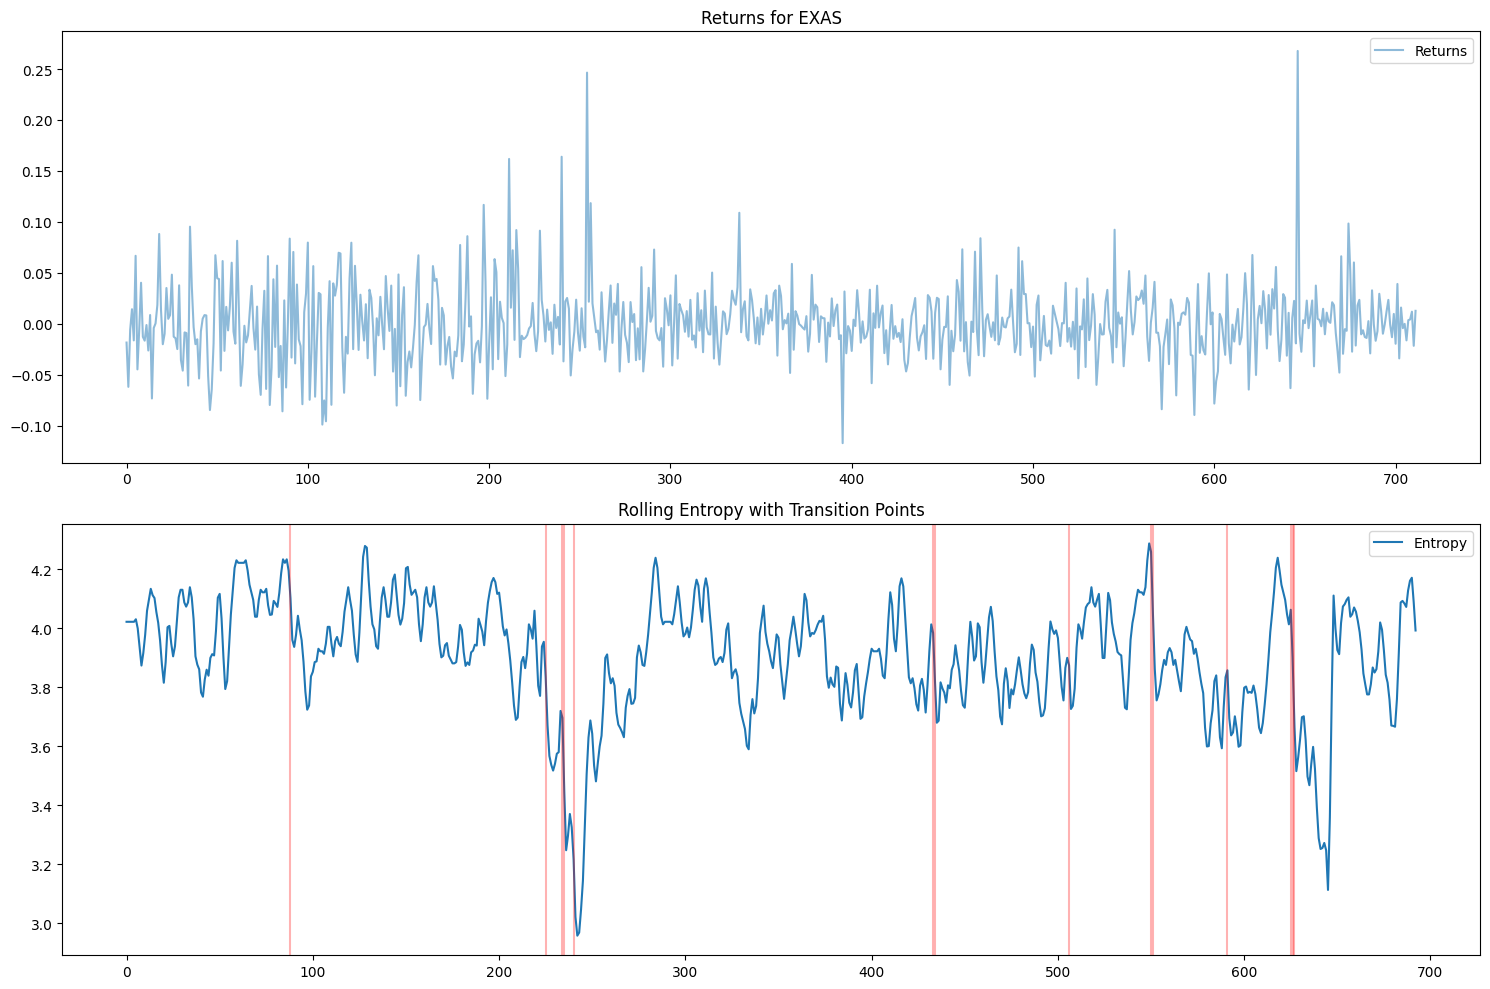

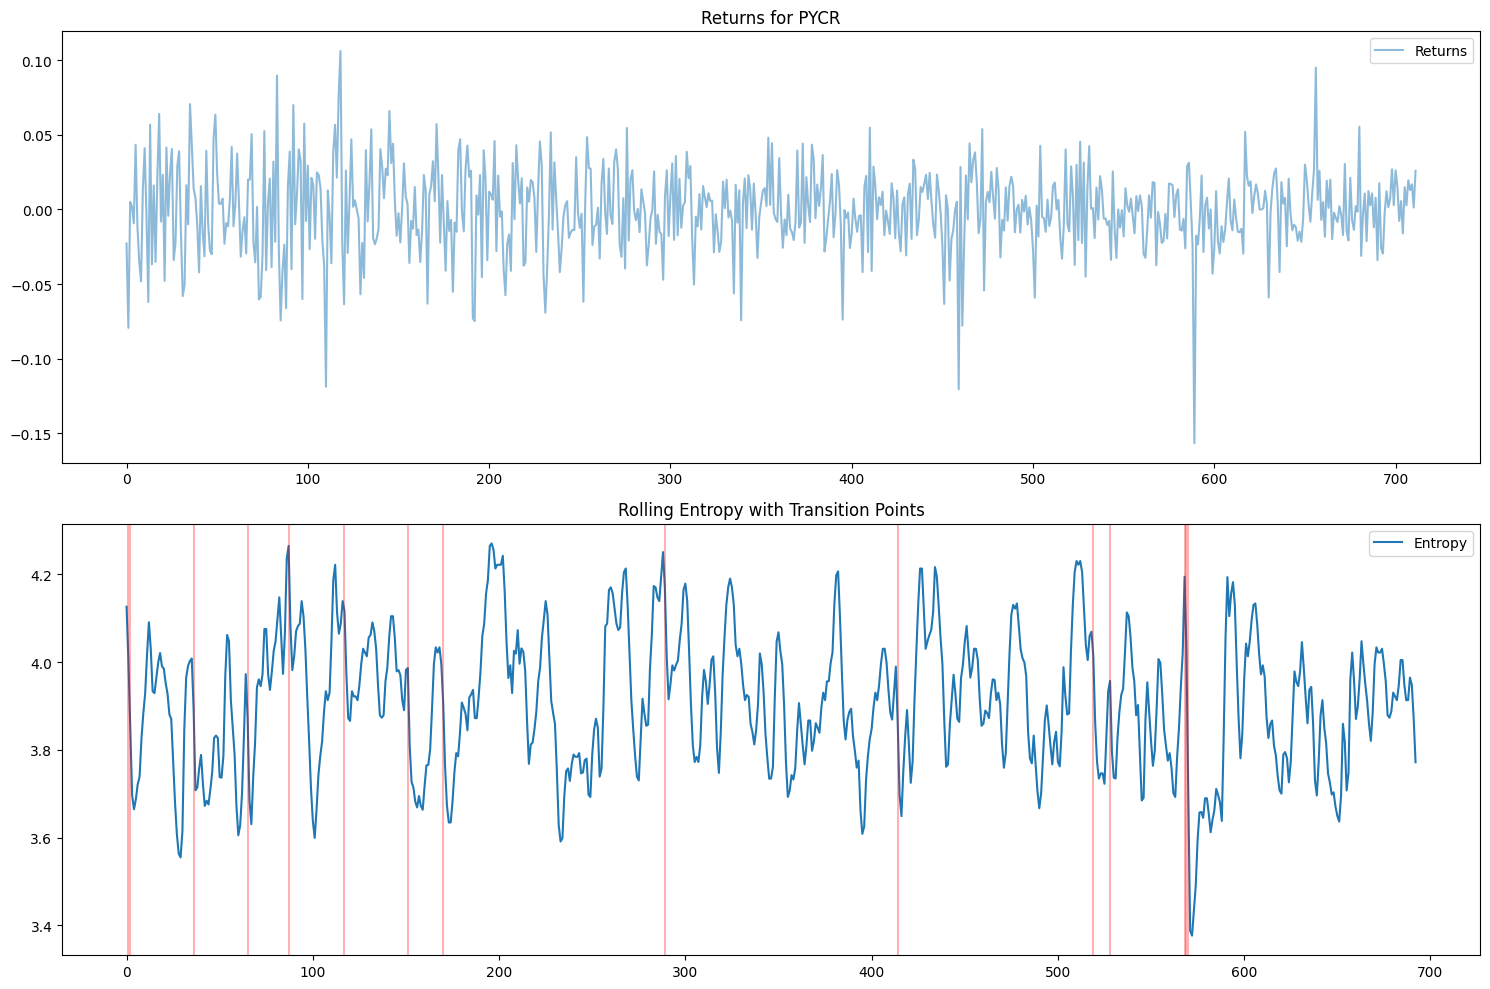

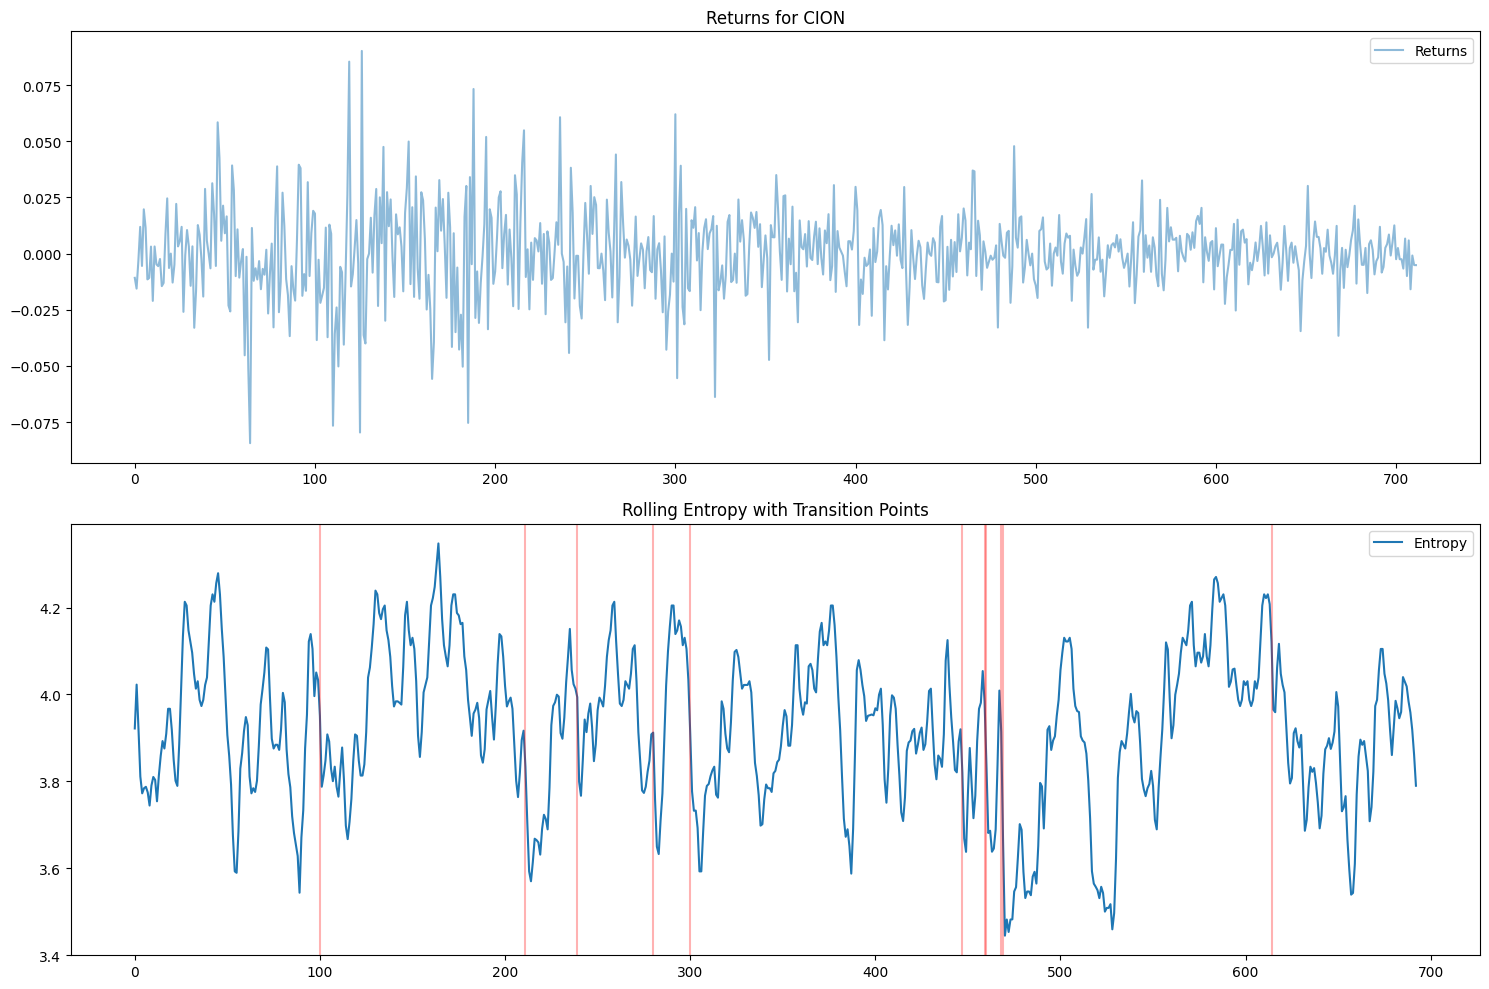

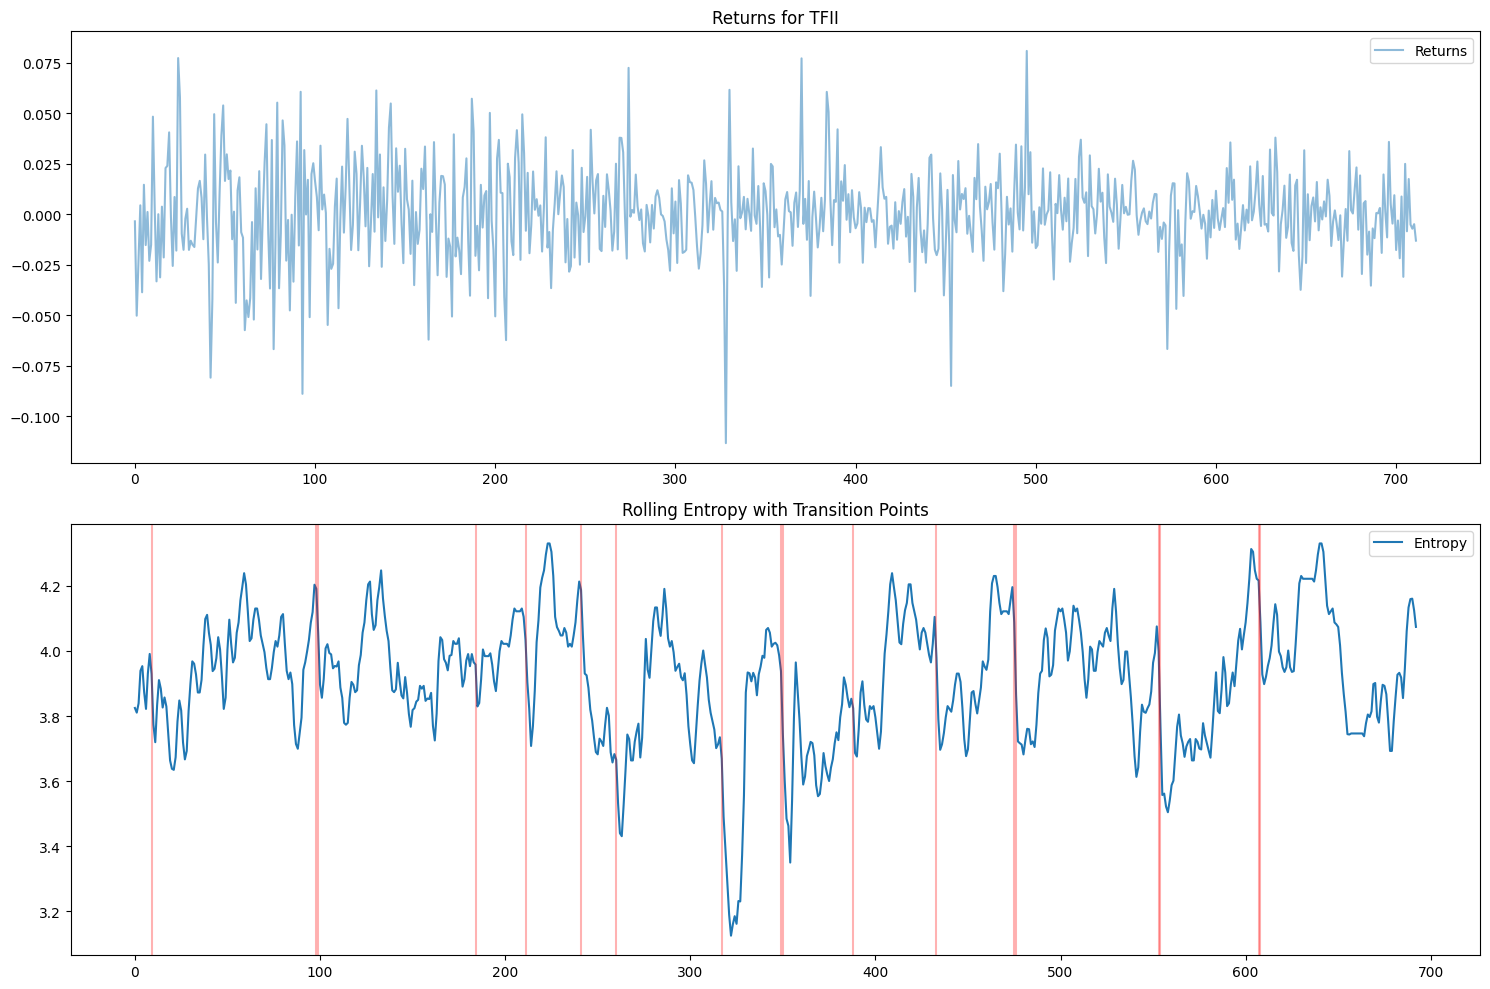

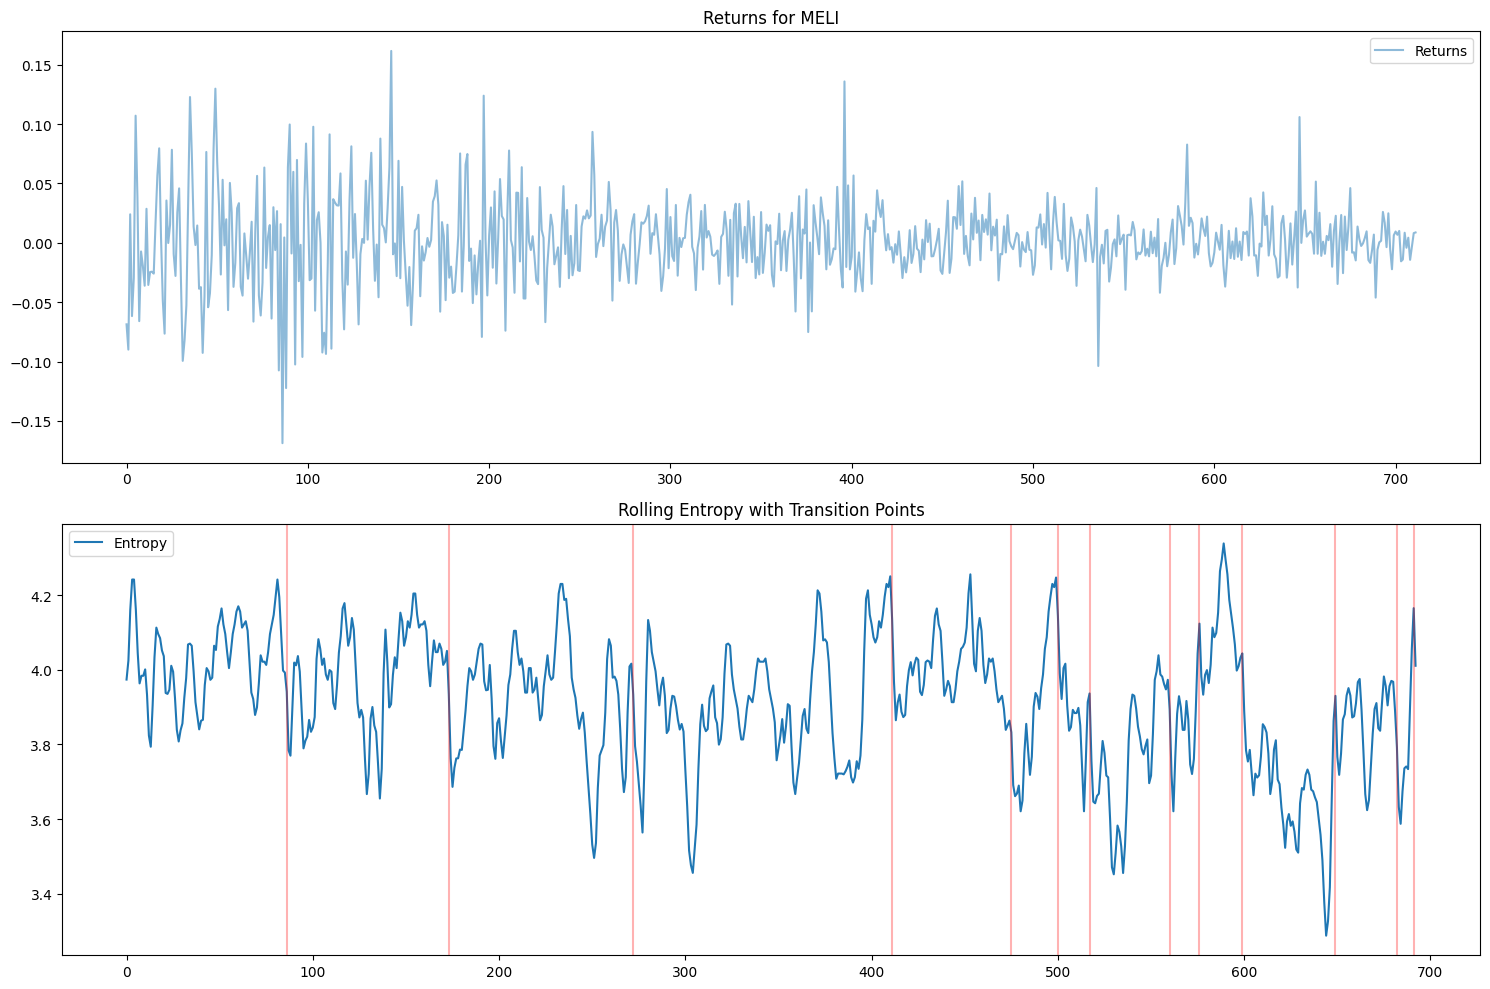

   num_transitions  avg_entropy_drop  avg_volatility_after symbol
0               14         -0.179264              0.028084   EXAS
1               15         -0.184694              0.024362   PYCR
2               11         -0.168392              0.016984   CION
3               18         -0.162132              0.018212   TFII
4               13         -0.158460              0.022789   MELI


In [3]:


import pandas as pd
import numpy as np
from scipy import stats, signal
import glob
import random
import os
from tqdm import tqdm
from typing import List, Dict
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


class EntropyTransitionAnalyzer:
    def __init__(self, base_analyzer: PredictionHorizonAnalyzer):
        self.base = base_analyzer
        
    def calculate_rolling_entropy(self, data: np.array, window: int = 20) -> np.array:
        """Calculate rolling window entropy"""
        rolling_entropy = []
        for i in range(len(data) - window + 1):
            window_data = data[i:i+window]
            entropy = self.base.calculate_shannon_entropy(window_data)
            rolling_entropy.append(entropy)
        return np.array(rolling_entropy)
    
    def detect_entropy_transitions(self, returns: np.array, 
                                 window: int = 20,
                                 smoothing_window: int = 5,
                                 threshold_std: float = 2.0) -> Tuple[List[int], np.array]:
        """
        Detect significant drops in entropy
        Returns: (transition_indices, smoothed_entropy)
        """
        # Calculate rolling entropy
        rolling_entropy = self.calculate_rolling_entropy(returns, window)
        
        # Smooth entropy signal
        smoothed_entropy = signal.savgol_filter(rolling_entropy, 
                                              smoothing_window, 
                                              3)  # polynomial order 3
        
        # Find significant drops
        entropy_diff = np.diff(smoothed_entropy)
        mean_diff = np.mean(entropy_diff)
        std_diff = np.std(entropy_diff)
        
        # Find points where entropy drops significantly
        transition_points = np.where(entropy_diff < (mean_diff - threshold_std * std_diff))[0]
        
        return transition_points, smoothed_entropy

    def calculate_post_transition_volatility(self, returns: np.array, transitions: np.array, 
                                          forward_window: int = 5) -> float:
        """Calculate average volatility after transition points"""
        if len(transitions) == 0:
            return 0
            
        volatilities = []
        for t in transitions:
            if t + forward_window < len(returns):
                vol = np.std(returns[t:t + forward_window])
                volatilities.append(vol)
        
        return np.mean(volatilities) if volatilities else 0

    def analyze_symbol(self, symbol: str, window: int = 20) -> dict:
        """Analyze entropy transitions for a single symbol"""
        df = self.base.datasets[symbol]['data']
        returns = df['Close'].pct_change().dropna().values
        
        transitions, entropy = self.detect_entropy_transitions(returns, window)
        
        # Calculate characteristics around transitions
        transition_stats = {
            'num_transitions': len(transitions),
            'avg_entropy_drop': np.mean(np.diff(entropy)[transitions]) if len(transitions) > 0 else 0,
            'avg_volatility_after': self.calculate_post_transition_volatility(returns, transitions)
        }
        
        return {
            'transitions': transitions,
            'entropy': entropy,
            'stats': transition_stats
        }
    
    def plot_entropy_analysis(self, symbol: str, window: int = 20):
        """Plot entropy analysis for a symbol"""
        df = self.base.datasets[symbol]['data']
        returns = df['Close'].pct_change().dropna().values
        analysis = self.analyze_symbol(symbol, window)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot returns
        ax1.plot(returns, alpha=0.5, label='Returns')
        ax1.set_title(f'Returns for {symbol}')
        ax1.legend()
        
        # Plot entropy
        ax2.plot(analysis['entropy'], label='Entropy')
        for t in analysis['transitions']:
            ax2.axvline(x=t, color='r', alpha=0.3)
        ax2.set_title('Rolling Entropy with Transition Points')
        ax2.legend()
        
        plt.tight_layout()
        return fig

# Example usage remains the same
def analyze_entropy_transitions(base_analyzer: PredictionHorizonAnalyzer, 
                              num_samples: int = 5) -> pd.DataFrame:
    """Analyze entropy transitions across multiple symbols"""
    transition_analyzer = EntropyTransitionAnalyzer(base_analyzer)
    
    # Sample some symbols
    symbols = random.sample(list(base_analyzer.datasets.keys()), num_samples)
    
    results = []
    for symbol in symbols:
        analysis = transition_analyzer.analyze_symbol(symbol)
        stats = analysis['stats']
        stats['symbol'] = symbol
        results.append(stats)
        
        # Plot analysis
        transition_analyzer.plot_entropy_analysis(symbol)
        plt.show()
    
    return pd.DataFrame(results)




if __name__ == "__main__":
    base_analyzer = PredictionHorizonAnalyzer(num_files=3000)
    base_analyzer.load_random_files()
    base_analyzer.analyze_horizons()

    # Analyze entropy transitions
    entropy_results = analyze_entropy_transitions(base_analyzer, num_samples=5)
    print(entropy_results)







Analyzing transitions: 100%|██████████| 3000/3000 [01:37<00:00, 30.70it/s]


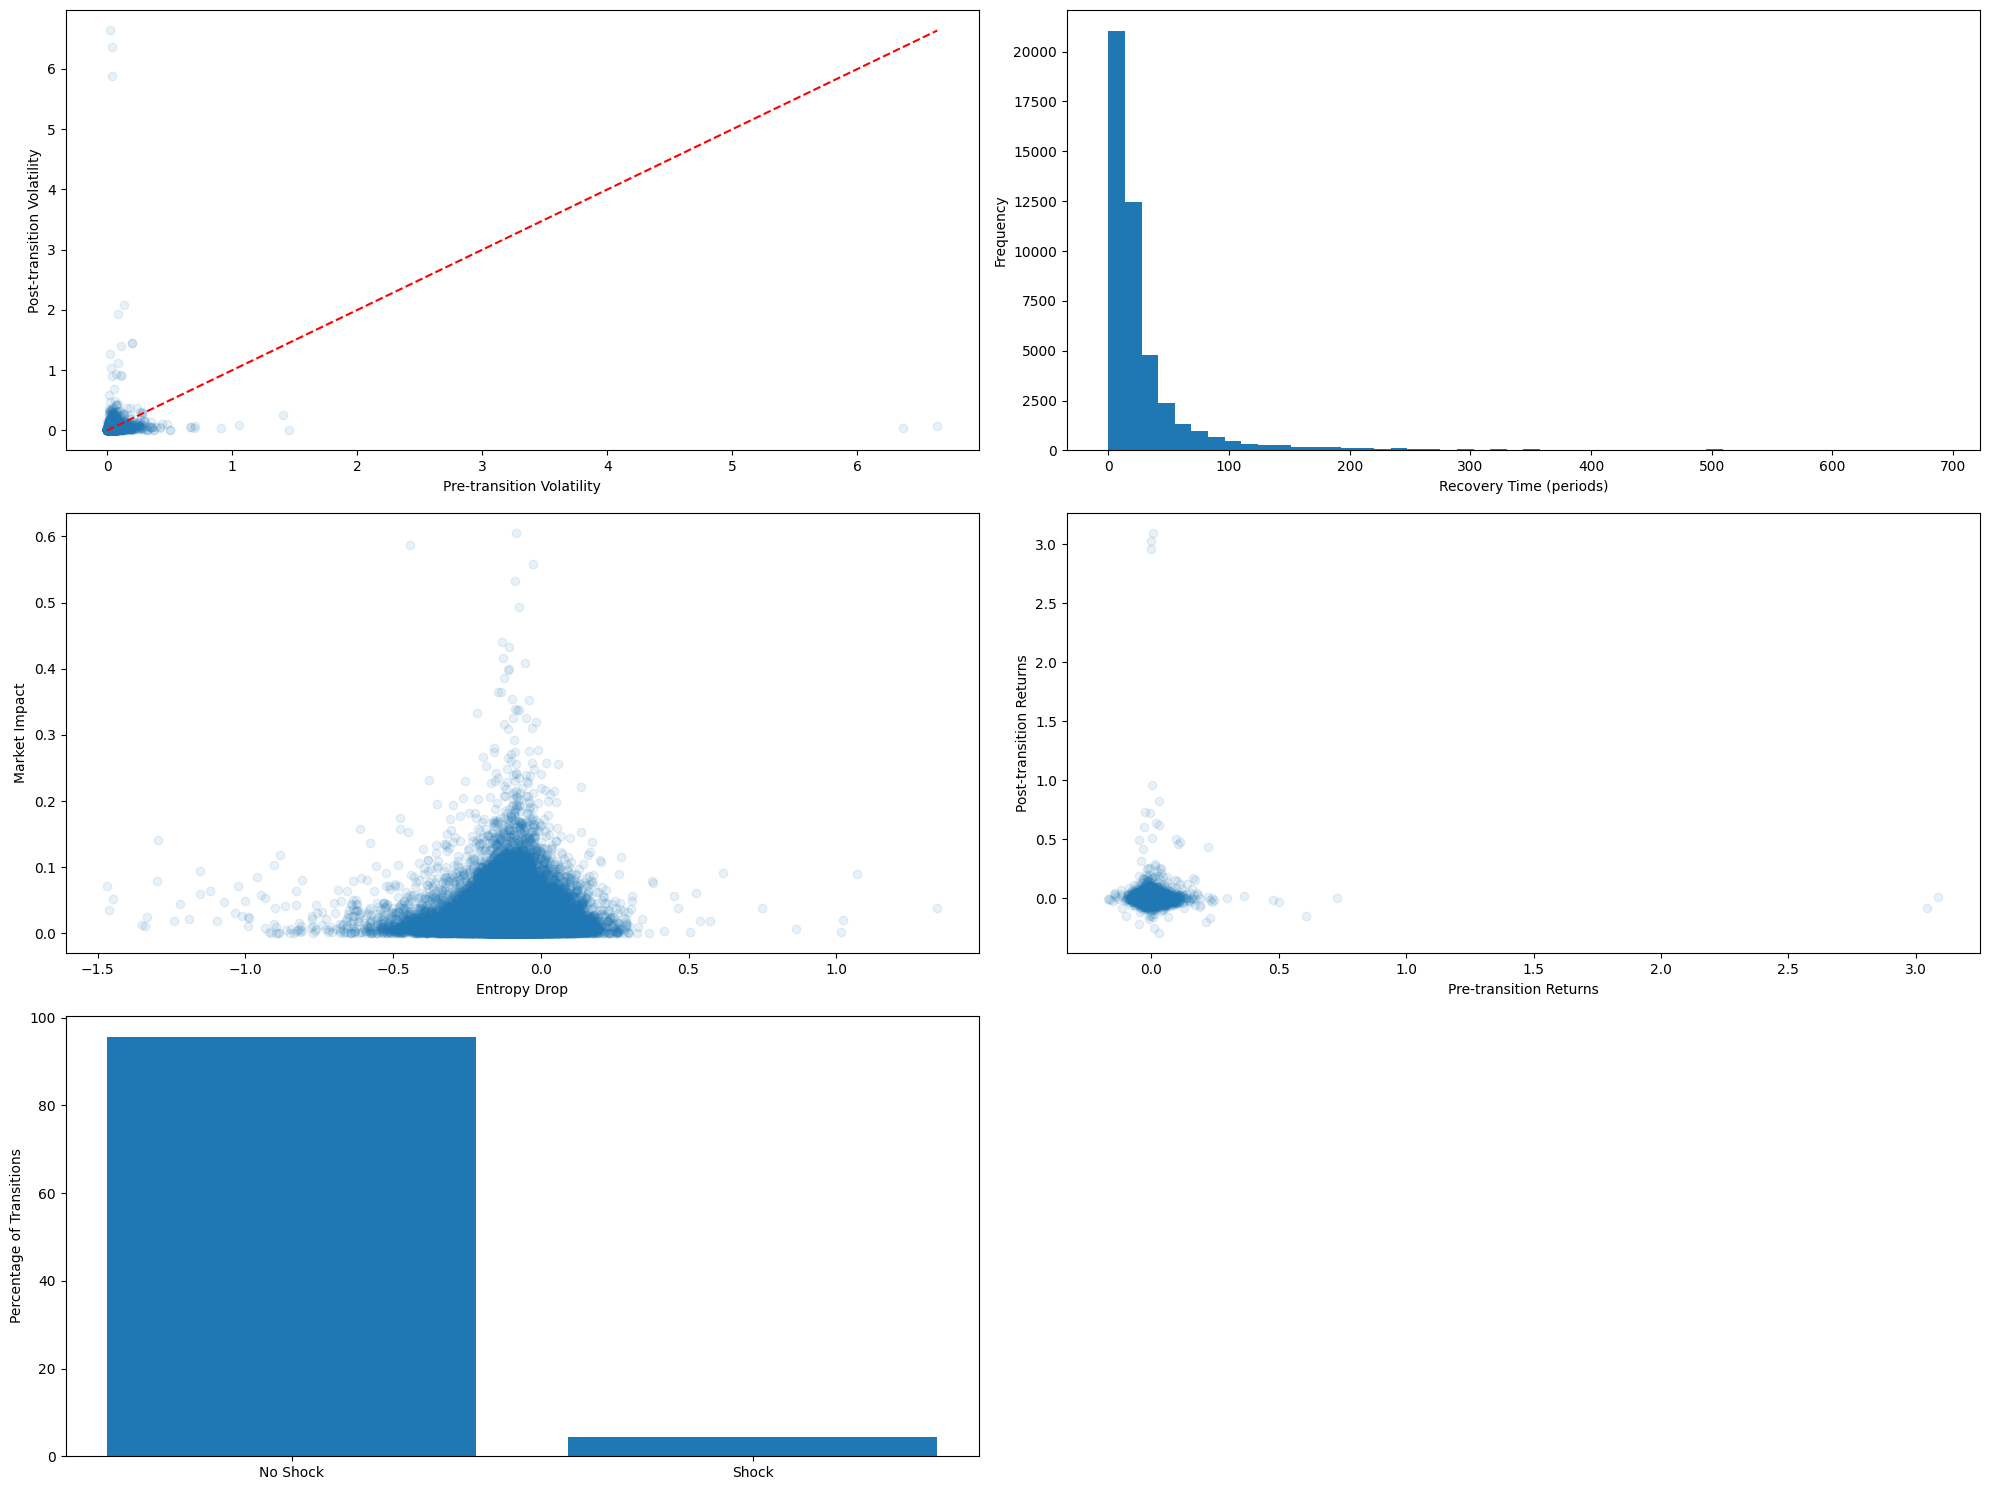


Transition Zone Characteristics:
       pre_volatility  post_volatility  entropy_drop    pre_return  \
count    46966.000000     46966.000000  46966.000000  46966.000000   
mean         0.022798         0.022651     -0.094566      0.000546   
std          0.049244         0.058705      0.105572      0.025781   
min          0.000000         0.000000     -1.468317     -0.168788   
25%          0.009826         0.009656     -0.141890     -0.005757   
50%          0.016615         0.016393     -0.087283      0.000184   
75%          0.027968         0.027265     -0.037103      0.005881   
max          6.637860         6.646179      1.342180      3.089426   

        post_return  recovery_time  market_impact  
count  46966.000000   46966.000000   46966.000000  
mean       0.000810      34.155645       0.022820  
std        0.030466      66.896141       0.026260  
min       -0.299220       0.000000       0.000000  
25%       -0.005418       7.000000       0.006579  
50%        0.000181    

In [4]:



import pandas as pd
import numpy as np
from scipy import stats, signal
import glob
import random
import os
from tqdm import tqdm
from typing import List, Dict
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


class TransitionPatternAnalyzer(EntropyTransitionAnalyzer):
    def __init__(self, base_analyzer: PredictionHorizonAnalyzer):
        super().__init__(base_analyzer)
        self.aggregate_stats = {}
        
    def analyze_transition_characteristics(self, returns: np.array, 
                                        transitions: np.array,
                                        entropy: np.array,
                                        window: int = 5) -> dict:
        """Analyze detailed characteristics of transition zones"""
        if len(transitions) == 0:
            return None
            
        characteristics = []
        for t in transitions:
            if t + window >= len(returns) or t - window < 0:
                continue
                
            char = {
                'pre_volatility': np.std(returns[t-window:t]),
                'post_volatility': np.std(returns[t:t+window]),
                'entropy_drop': entropy[t] - entropy[t-1] if t > 0 else 0,
                'pre_return': np.mean(returns[t-window:t]),
                'post_return': np.mean(returns[t:t+window]),
                'recovery_time': self._calculate_recovery_time(entropy[t:], entropy[t-1]),
                'market_impact': np.abs(returns[t]),
                'volume_shock': True if t < len(returns)-1 and np.abs(returns[t+1]) > 2*np.std(returns) else False
            }
            characteristics.append(char)
            
        return pd.DataFrame(characteristics)
    
    def _calculate_recovery_time(self, future_entropy: np.array, 
                               pre_transition_entropy: float) -> int:
        """Calculate how long it takes entropy to recover after transition"""
        if len(future_entropy) == 0:
            return 0
        recovery_idx = np.where(future_entropy >= pre_transition_entropy)[0]
        return recovery_idx[0] if len(recovery_idx) > 0 else len(future_entropy)
    
    def analyze_all_stocks(self) -> pd.DataFrame:
        """Analyze transition patterns across all stocks"""
        all_transitions = []
        
        for symbol in tqdm(self.base.datasets.keys(), desc="Analyzing transitions"):
            df = self.base.datasets[symbol]['data']
            returns = df['Close'].pct_change().dropna().values
            transitions, entropy = self.detect_entropy_transitions(returns)
            
            chars = self.analyze_transition_characteristics(returns, transitions, entropy)
            if chars is not None:
                chars['symbol'] = symbol
                all_transitions.append(chars)
        
        return pd.concat(all_transitions, ignore_index=True)
    
    def plot_transition_patterns(self, all_transitions: pd.DataFrame):
        """Create visualization of transition patterns"""
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Volatility Change
        ax1 = fig.add_subplot(321)
        ax1.scatter(all_transitions['pre_volatility'], 
                   all_transitions['post_volatility'],
                   alpha=0.1)
        ax1.set_xlabel('Pre-transition Volatility')
        ax1.set_ylabel('Post-transition Volatility')
        ax1.plot([0, max(all_transitions['pre_volatility'])], 
                [0, max(all_transitions['pre_volatility'])], 
                'r--')
        
        # 2. Recovery Time Distribution
        ax2 = fig.add_subplot(322)
        ax2.hist(all_transitions['recovery_time'], bins=50)
        ax2.set_xlabel('Recovery Time (periods)')
        ax2.set_ylabel('Frequency')
        
        # 3. Entropy Drop vs Market Impact
        ax3 = fig.add_subplot(323)
        ax3.scatter(all_transitions['entropy_drop'], 
                   all_transitions['market_impact'],
                   alpha=0.1)
        ax3.set_xlabel('Entropy Drop')
        ax3.set_ylabel('Market Impact')
        
        # 4. Pre vs Post Returns
        ax4 = fig.add_subplot(324)
        ax4.scatter(all_transitions['pre_return'], 
                   all_transitions['post_return'],
                   alpha=0.1)
        ax4.set_xlabel('Pre-transition Returns')
        ax4.set_ylabel('Post-transition Returns')
        
        # 5. Volume Shock Analysis
        ax5 = fig.add_subplot(325)
        shock_pct = all_transitions['volume_shock'].mean() * 100
        ax5.bar(['No Shock', 'Shock'], 
                [100-shock_pct, shock_pct])
        ax5.set_ylabel('Percentage of Transitions')
        
        plt.tight_layout()
        return fig

def analyze_market_patterns(base_analyzer: PredictionHorizonAnalyzer):
    """Main analysis function"""
    pattern_analyzer = TransitionPatternAnalyzer(base_analyzer)
    
    # Analyze all transitions
    all_transitions = pattern_analyzer.analyze_all_stocks()
    
    # Plot patterns
    pattern_analyzer.plot_transition_patterns(all_transitions)
    plt.show()
    
    # Print summary statistics
    print("\nTransition Zone Characteristics:")
    print(all_transitions.describe())
    
    # Find unusual cases
    unusual_cases = all_transitions[
        (all_transitions['entropy_drop'] < all_transitions['entropy_drop'].quantile(0.05)) |
        (all_transitions['market_impact'] > all_transitions['market_impact'].quantile(0.95))
    ]
    
    print("\nUnusual Transition Cases:")
    print(unusual_cases.groupby('symbol').size().sort_values(ascending=False).head())
    
    return all_transitions, unusual_cases

# Usage
base_analyzer = PredictionHorizonAnalyzer(num_files=3000)
base_analyzer.load_random_files()
transitions_df, unusual_cases = analyze_market_patterns(base_analyzer)